# Lisbon MBA Toastmasters enjoy giving feedback to speakers

Toastmasters is a non-profit organisation that provides a space for its members to learn public speaking and leadership skills through deliberate practice and constant feedback about this practice, under a structured development program. The Lisbon MBA Toastmasters Club is a Toastmasters club located in the Nova School of Business and Economics, in Carcavelos, Portugal.

At each Toastmasters meeting, each member can perform one of a multitude of roles that allow them to enhance their leadership and public speaking skills. Meetings at the Lisbon MBA Toastmasters Club take place on Wednesdays, every two weeks.

For this development program to succeed, it is essential for the club to retain a minimum number of members in order to form an encouraging and dynamic learning environment in which members provide feedback to each other during their developmental process. It is therefore essential for the club to provide the conditions for members to remain committed to their learning journey. 

We would like to predict when a member is thinking about leaving the club and to get a glimpse on which roles may capture more interest among club members during a meeting. These insights may allow the Club Executive Committee to intervene in order to incentivize members to stay and encourage members to take some roles more frequently in order to gain commitment to their skill development. We gathered meeting data from current and past members of the Lisbon MBA Toastmasters Club and tried to predict whether they stayed or left the club. The dataset only includes meetings that occurred during the 2022/2023 season. Our dataset is small, so I have built many different classification models in order to capture insights that can be captured across different models.

I have found that:

- ### Members missing more than $40$ days of meetings are probably leaving the club;
- ### Evaluator is the most important role separating members that stay from members that leave;
- ### Speaker and table topic speaker are likely crucial roles, as expected, but evidence is inconsistent.

Do members become more commited to their development after taking on these roles? 

Or do they take on these roles ever more frequently after they gain more commitment to their developmental journey?

Perhaps a bit of both, but perhaps the Executive Committee can help members remain committed to their journey.



### I recommend the Club Executive Committee to:
- ### Encourage members to take on the evaluator, the speaker and the table topic speaker roles as soon as possible after joining the club
- ### Engage with members who have been missing more than two Toastmasters meetings in a row. 

In a club that meets twice a month, a member misses meetings for $28$ days by missing two sessions in a row; by missing a third session in a row, the member will be missing over $40$ days of meetings already.

Below I show the classification models that led me to these insights.

### Table of Contents

[Importing members and features](#data)

[Correlation between features](#correlation)

[Modeling churn I: Using Meetings Attended, Last Presence and Joined](#churn1)

[Modeling churn II: Using meeting roles only](#churn2)

[Discussion](#discussion)

### Importing packages

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
# A function to plot a confusion matrix
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"

    sns.set(rc={"figure.figsize":(4, 3)})
    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, cmap='Blues', annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Reality')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Stayed', 'Left']); ax.yaxis.set_ticklabels(['Stayed', 'Left'])

<a id='data'></a>
## Importing members and features

For each member, we have the following features:
- `Last Presence` - when the last meeting the member has attended took place;
- `Joined` - when the member joined the club;
- `Meetings Attended` - fraction of meetings the member has attended in the 2022/2023 season, i.e. the quotient between the number of meetings attended and the number of meetings that took place during membership.

All remaining features refer to the many different meeting roles. They represent the number of times the member has taken on a given role at a meeting during the 2022/2023 season. The roles under analysis are:
- Toastmaster, `TME` - the meeting's director and host;
- `Speaker` - prepares, rehearses and presents a speech during the club meeting;
- `Evaluator` - provides verbal and written feedback to a meeting speaker;
- Table topics master, `TTM` - delivers the Table Topics portion of the meeting, which helps train members to quickly organize and express their thoughts in an _impromptu_ setting;
- Table topic speaker, `TTS` - delivers an _impromptu_ speech on a topic provided by the table topics master;
- Timekeeper, `TK` - monitors time for each meeting segment and each intervention during the meeting;
- Ah-counter, `AhC` - takes note of all overused words or filler sounds used by other members during their interventions at the meeting;
- Grammarian, `Gr` - introduces new words to meeting participants and monitors the language and grammar usage by all members, noting incomplete sentences, mispronunciations, grammatical mistakes, non-sequiturs, malapropisms, etc;
- General evaluator, `GE` - evaluates everything that takes place during the club meeting.

`Churn` is our response variable, taking a value of $1$ if the member has left the club and $0$ if a member has stayed in the club.

In [3]:
tm_member_info = pd.read_csv('TM members.csv',index_col='Member',decimal=',',
                             usecols=['Member','Joined','Last Presence','TME','GE','TTM','Speaker','Evaluator','TTS','TK','AhC','Gr','Meetings Attended','Year Meetings as Member','Churn'])
tm_member_info.head()

,Joined,TME,GE,TTM,Speaker,Evaluator,TTS,TK,AhC,Gr,Last Presence,Meetings Attended,Year Meetings as Member,Churn
Member,,,,,,,,,,,,,,
0DUskTCnCDPiF2Ra9je5UiVR2b7W,23-01-2023,0,0,1,1,0,0,0,1,0,15-05-2023,0.50,14,1
2MmBWKdDt6Bv7jksDvSZM4SgZ9wJ,22-11-2016,1,1,3,1,1,1,3,1,3,26-07-2023,0.87,23,0
2Z1PQ9200RyXzg9WbTa10S4igYeK,01-04-2022,0,0,1,3,0,3,1,2,0,12-07-2023,0.74,23,0
6TW4zYLA2cnSi8gDvbknHASu3atN,22-03-2022,1,0,1,2,0,4,1,3,2,26-07-2023,0.65,23,0
7a01j1pQcAlB5DVe6pUnwgLhhlY8,11-11-2021,0,0,0,0,0,0,0,0,0,29-06-2022,0.00,23,1


We have fairly balanced dataset on $28$ current and past members of Lisbon MBA Toastmasters, of which $53.6\%$ are still at the club and $46.4\%$ have left the club.

In [4]:
member_fate = tm_member_info['Churn'].value_counts()
fate_mapping = {0:'Stayed', 1:'Left'}
member_fate_mapped = member_fate.rename(index=fate_mapping)

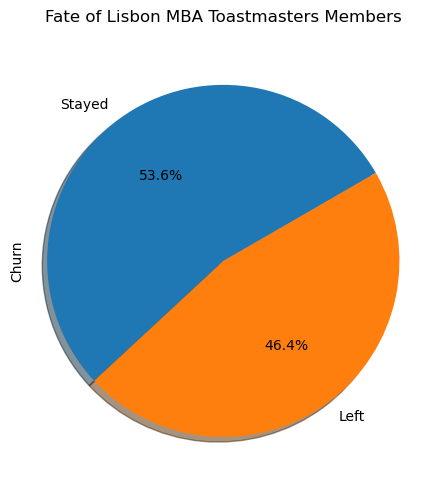

In [5]:
# autopct create %, start angle represent starting point
member_fate_mapped.plot(kind='pie',
                            figsize=(5, 6),
                            startangle=30,     # start angle 90° (Africa)
                            autopct='%1.1f%%', # add in percentages
                            shadow=True,       # add shadow
                            ylabel=None
                            )

plt.title('Fate of Lisbon MBA Toastmasters Members')
plt.axis('equal') # Sets the pie chart to look like a circle.

plt.show()

In [6]:
#Converting dates `Last Presence` and `Joined` to the `datetime` type
tm_member_info[['Joined','Last Presence']] = tm_member_info[['Joined','Last Presence']].apply(pd.to_datetime,dayfirst=True)
tm_member_info.head(2)

,Joined,TME,GE,TTM,Speaker,Evaluator,TTS,TK,AhC,Gr,Last Presence,Meetings Attended,Year Meetings as Member,Churn
Member,,,,,,,,,,,,,,
0DUskTCnCDPiF2Ra9je5UiVR2b7W,2023-01-23,0,0,1,1,0,0,0,1,0,2023-05-15,0.50,14,1
2MmBWKdDt6Bv7jksDvSZM4SgZ9wJ,2016-11-22,1,1,3,1,1,1,3,1,3,2023-07-26,0.87,23,0


Converting `Joined` and `Last Presence` to a time difference: we are using the number of days that have passed between the listed date and July $31^{st}$ 2023, the date we will use as a reference. This date closely follows the last meeting of the season.

In [7]:
tm_member_info[['Joined','Last Presence']] = dt.datetime(2023,7,31) - tm_member_info[['Joined','Last Presence']]
tm_member_info.head(2)

,Joined,TME,GE,TTM,Speaker,Evaluator,TTS,TK,AhC,Gr,Last Presence,Meetings Attended,Year Meetings as Member,Churn
Member,,,,,,,,,,,,,,
0DUskTCnCDPiF2Ra9je5UiVR2b7W,189 days,0,0,1,1,0,0,0,1,0,77 days,0.50,14,1
2MmBWKdDt6Bv7jksDvSZM4SgZ9wJ,2442 days,1,1,3,1,1,1,3,1,3,5 days,0.87,23,0


We can see in the table above that _0DUskTCnCDPiF2Ra9je5UiVR2b7W_ has joined the club $189$ days ago and the last time (s)he was at a club session was $77$ days ago, taking July $31^{st}$ 2023 as the reference date. This means that $189$ days have passed from the day this member has joined until July $31^{st}$ 2023 and $77$ days have passed since the last time this member joined a meeting up until July $31^{st}$ 2023.

In [8]:
#Converting dates `Last Presence` and `Joined` to the `timedelta` type
tm_member_info[['Joined','Last Presence']] = tm_member_info[['Joined','Last Presence']].astype('timedelta64[D]')
tm_member_info.head(2)

,Joined,TME,GE,TTM,Speaker,Evaluator,TTS,TK,AhC,Gr,Last Presence,Meetings Attended,Year Meetings as Member,Churn
Member,,,,,,,,,,,,,,
0DUskTCnCDPiF2Ra9je5UiVR2b7W,189.0,0,0,1,1,0,0,0,1,0,77.0,0.50,14,1
2MmBWKdDt6Bv7jksDvSZM4SgZ9wJ,2442.0,1,1,3,1,1,1,3,1,3,5.0,0.87,23,0


The number of roles taken by a member shall be a good indicator of her/his commitment to learning in the club. However, this number is influenced by the number of meetings in the season that took place after the member joined the club. Some people might have taken on less roles simply because they have entered the club in the middle of the season, so they had the chance to attend less meetings. To take this fact into account, I have divided, for each role, the number of times the role was taken, $r$, by the number of meetings this member had the chance to attend in the club during the season, $m$:

$$ r^{*} = \frac{r}{m} $$

$m$ can be seen in the `Year Meetings as Member` column of the table above. These $r^{*}$ values were the ones used in further analyses.

In [9]:
tm_member_info[['TME','GE','TTM','Speaker','Evaluator','TTS','TK','AhC','Gr']] = tm_member_info[['TME','GE','TTM','Speaker','Evaluator','TTS','TK','AhC','Gr']].apply(lambda x: x/tm_member_info['Year Meetings as Member'])
tm_member_info.head()

,Joined,TME,GE,TTM,Speaker,Evaluator,TTS,TK,AhC,Gr,Last Presence,Meetings Attended,Year Meetings as Member,Churn
Member,,,,,,,,,,,,,,
0DUskTCnCDPiF2Ra9je5UiVR2b7W,189.0,0.000000,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.071429,0.000000,77.0,0.50,14,1
2MmBWKdDt6Bv7jksDvSZM4SgZ9wJ,2442.0,0.043478,0.043478,0.130435,0.043478,0.043478,0.043478,0.130435,0.043478,0.130435,5.0,0.87,23,0
2Z1PQ9200RyXzg9WbTa10S4igYeK,486.0,0.000000,0.000000,0.043478,0.130435,0.000000,0.130435,0.043478,0.086957,0.000000,19.0,0.74,23,0
6TW4zYLA2cnSi8gDvbknHASu3atN,496.0,0.043478,0.000000,0.043478,0.086957,0.000000,0.173913,0.043478,0.130435,0.086957,5.0,0.65,23,0
7a01j1pQcAlB5DVe6pUnwgLhhlY8,627.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,397.0,0.00,23,1


Let's separate the response variable `Churn` in `y` from all other, predictor, features in `X` and generate training and test sets.

In [10]:
y = tm_member_info['Churn'].values
X = tm_member_info[['Joined','Last Presence','TME','GE','TTM','Speaker','Evaluator','TTS','TK','AhC','Gr','Meetings Attended']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=56, stratify=y)

f'{len(X_train)} members in the training set; {len(X_test)} members in the test set'

'19 members in the training set; 9 members in the test set'

<a id='correlation'></a>
## Correlation between features

<Axes: >

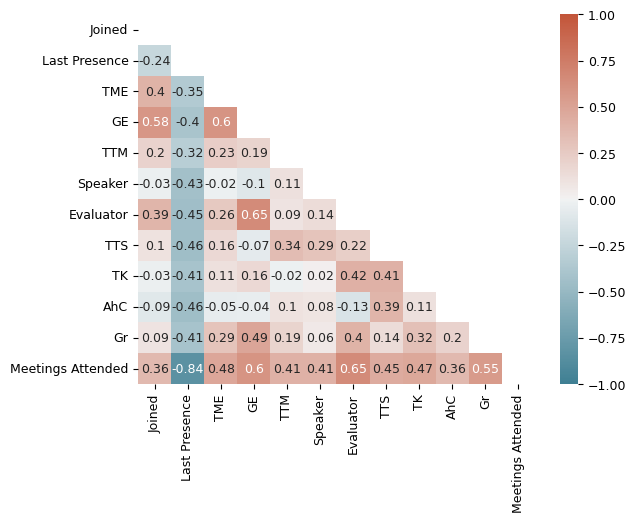

In [11]:
X_feature_corr = X.corr().round(decimals=2)

# Create colour map
# We create a new colour map with the colours
cmap = sns.diverging_palette(220, 20, as_cmap=True)
# We also create a mask matrix in order to plot a triangular matrix only
mask = np.triu(np.ones_like(X_feature_corr, dtype=bool))

plt.rcParams['font.size'] = 9
sns.heatmap(X_feature_corr, annot=True,center=0,vmin=-1,vmax=1,cmap=cmap, mask = mask)

`Last Presence` is strongly correlated with `Meetings Attended` and both of these features are moderately correlated with all meeting roles. On one hand, it seems intuitive that members who have been coming to the most recent meetings have been coming to a higher fraction of meetings. On the other hand, it also seems intuitive that members coming to the most recent meetings and coming to a higher fraction of meetings are more likely to be the members that perform more meeting roles in general.

For these reasons, I have decided to model churn in two separate approaches, using separate feature sets:
 1. Using only `Last Presence`, `Meetings Attended` and `Joined`;
 2. Using only meeting roles.

`Last Presence` and `Meetings Attended` are very strongly correlated, with a correlation of $-0.84$, so information contained in both features is somewhat redundant. Therefore, we should also remove one of these features at the time from our analysis in order to discern the impact of each of these highly correlated features.

For the first approach we will consider three different matrices:
 - `X1`, which will include `Last Presence`, `Meetings Attended` and `Joined`;

In [12]:
X1 = X[['Joined','Last Presence','Meetings Attended']]
X1.head(2)

,Joined,Last Presence,Meetings Attended
Member,,,
0DUskTCnCDPiF2Ra9je5UiVR2b7W,189.0,77.0,0.50
2MmBWKdDt6Bv7jksDvSZM4SgZ9wJ,2442.0,5.0,0.87


 - `X1m`, which will include only `Meetings Attended` and `Joined`;

In [13]:
X1m = X[['Joined','Meetings Attended']]
X1m.head(2)

,Joined,Meetings Attended
Member,,
0DUskTCnCDPiF2Ra9je5UiVR2b7W,189.0,0.50
2MmBWKdDt6Bv7jksDvSZM4SgZ9wJ,2442.0,0.87


 - `X1p`, which will include only `Last Presence` and `Joined`.

In [14]:
X1p = X[['Joined','Last Presence']]
X1p.head(2)

,Joined,Last Presence
Member,,
0DUskTCnCDPiF2Ra9je5UiVR2b7W,189.0,77.0
2MmBWKdDt6Bv7jksDvSZM4SgZ9wJ,2442.0,5.0


For the second approach, we define the `X2` matrix, which will only include the meeting roles.

In [15]:
X2 = X.drop(columns=['Joined','Last Presence','Meetings Attended'])
X2.head(2)

,TME,GE,TTM,Speaker,Evaluator,TTS,TK,AhC,Gr
Member,,,,,,,,,
0DUskTCnCDPiF2Ra9je5UiVR2b7W,0.000000,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.071429,0.000000
2MmBWKdDt6Bv7jksDvSZM4SgZ9wJ,0.043478,0.043478,0.130435,0.043478,0.043478,0.043478,0.130435,0.043478,0.130435


<a id='churn1'></a>
## Modelling churn I:
## Using `Meetings Attended`, `Last Presence` and `Joined`

Let's start by splitting our $28$ members into training sets, which will have $70\%$ of the members, and test sets, which will have the remaining $30\%$.

In [16]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.3, random_state=32, stratify=y)
X1m_train, X1m_test, y1m_train, y1m_test = train_test_split(X1m, y, test_size=0.3, random_state=32, stratify=y)
X1p_train, X1p_test, y1p_train, y1p_test = train_test_split(X1p, y, test_size=0.3, random_state=32, stratify=y)

print(len(X1_train),'members in the training set of X1;',len(X1_test),'members in the test set of X1')
print(len(X1m_train),'members in the training set of X1m;',len(X1m_test),'members in the test set of X1m')
print(len(X1p_train),'members in the training set of X1p;',len(X1p_test),'members in the test set of X1p')

19 members in the training set of X1; 9 members in the test set of X1
19 members in the training set of X1m; 9 members in the test set of X1m
19 members in the training set of X1p; 9 members in the test set of X1p


### Gradient boosting

In [17]:
lgbm_parameters = {'objective': ['binary'],
                  'boosting_type': ['gbdt'],
                  'n_estimators': [100],
                  'learning_rate': [0.002],
                  'deterministic': [False],
                  'force_col_wise': [True],
                  'max_depth': [1, 2],
                  'colsample_bytree': [0.15, 0.2, 0.25],
                  'min_split_gain': [0.05],
                  'min_child_samples': [7],
                  'min_data_in_bin': [2],
                   'verbose': [-1],
                  }

lgb_jmp = GridSearchCV(lgb.LGBMClassifier(random_state=52), lgbm_parameters, cv=4)
lgb_jmp.fit(X1_train, y1_train)

print("Tuned hyperparameters :",lgb_jmp.best_params_)
print("Accuracy on training data:",lgb_jmp.best_score_)
print("Accuracy on test data:",lgb_jmp.score(X1_test,y1_test))

Tuned hyperparameters : {'boosting_type': 'gbdt', 'colsample_bytree': 0.15, 'deterministic': False, 'force_col_wise': True, 'learning_rate': 0.002, 'max_depth': 1, 'min_child_samples': 7, 'min_data_in_bin': 2, 'min_split_gain': 0.05, 'n_estimators': 100, 'objective': 'binary', 'verbose': -1}
Accuracy on training data: 1.0
Accuracy on test data: 0.8888888888888888


An $88,9\%$ accuracy in our case means that the model was only unable to predict correcly the fate of $1$ of the members in the test data, as we can see in the confusion matrix below.

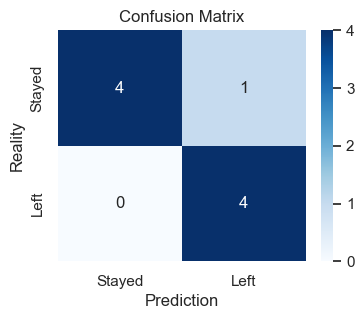

In [18]:
plot_confusion_matrix(y1_test,lgb_jmp.predict(X1_test))

Text(0.5, 1.0, 'Gradient Boosting')

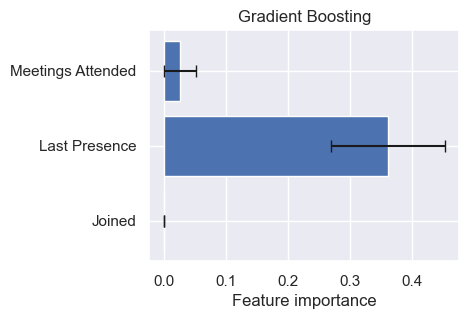

In [77]:
lgb_jmp_fi = permutation_importance(lgb_jmp, X1_train, y1_train,n_repeats=100,scoring='accuracy')

plt.barh(X1.columns,lgb_jmp_fi.importances_mean,xerr=lgb_jmp_fi.importances_std, capsize=4)
plt.xlabel('Feature importance')
plt.title('Gradient Boosting')

`Last Presence` seems to be the most important feature among these three separating members staying from members leaving.

### Random forest

In [20]:
#Random state 32
rf_parameters = {'criterion': ['entropy'],
                     'n_estimators': [50], 'min_samples_split': [5, 6, 7],
                     'min_samples_leaf': [3], 'max_depth': [1, 2],
                     'min_impurity_decrease': [0.3], 'max_features': ['sqrt', 'log2']}

In [21]:
rf_jmp = GridSearchCV(
    RandomForestClassifier(random_state=32),
    rf_parameters, cv=4,n_jobs=4)

rf_jmp.fit(X1_train,y1_train)

print("Tuned hyperparameters :",rf_jmp.best_params_)
print("Accuracy in training data:",rf_jmp.best_score_)
print("Accuracy in test data: ", rf_jmp.score(X1_test,y1_test))

Tuned hyperparameters : {'criterion': 'entropy', 'max_depth': 1, 'max_features': 'sqrt', 'min_impurity_decrease': 0.3, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy in training data: 1.0
Accuracy in test data:  0.8888888888888888


A similarly high accuracy to the one observed in the gradient boosting model. Again, `Last Presence` seems to be the most important feature separating members staying from members leaving.

Text(0.5, 1.0, 'Random Forest')

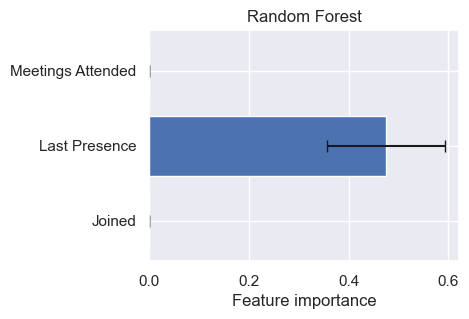

In [78]:
rf_jmp_fi = permutation_importance(rf_jmp, X1_train, y1_train,n_repeats=100,scoring='accuracy')

plt.barh(X1.columns,rf_jmp_fi.importances_mean,xerr=rf_jmp_fi.importances_std, capsize=4)
plt.xlabel('Feature importance')
plt.title('Random Forest')

## Using `Meetings Attended` and `Joined`
Given that `Meetings Attended` and `Last Presence` are highly correlated, as we have seen [above](#correlation), I am repeating the analysis by removing `Last Presence` to check how multicollinearity might influence the result we have just seen.

### Gradient boosting

In [23]:
lgbm_parameters = {'objective': ['binary'],
                  'boosting_type': ['gbdt'],
                  'n_estimators': [100],
                  'learning_rate': [0.0015],
                  'deterministic': [False],
                  'force_col_wise': [True],
                  'max_depth': [1, 2],
                  'colsample_bytree': [0.2, 0.25, 0.3],
                  'min_split_gain': [0.5],
                  'min_child_samples': [6],
                  'min_data_in_bin': [5],
                   'verbose': [-1]
                  }

lgb_jm = GridSearchCV(lgb.LGBMClassifier(random_state=22), lgbm_parameters, cv=4)
lgb_jm.fit(X1m_train, y1m_train)

print("Tuned hyperparameters :",lgb_jm.best_params_)
print("Accuracy on training data:",lgb_jm.best_score_)
print("Accuracy on test data:",lgb_jm.score(X1m_test,y1m_test))

Tuned hyperparameters : {'boosting_type': 'gbdt', 'colsample_bytree': 0.2, 'deterministic': False, 'force_col_wise': True, 'learning_rate': 0.0015, 'max_depth': 1, 'min_child_samples': 6, 'min_data_in_bin': 5, 'min_split_gain': 0.5, 'n_estimators': 100, 'objective': 'binary', 'verbose': -1}
Accuracy on training data: 0.95
Accuracy on test data: 0.8888888888888888


We can still obtain a very accurate model without `Last Presence`.

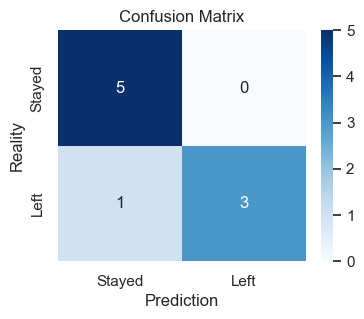

In [24]:
plot_confusion_matrix(y1m_test,lgb_jm.predict(X1m_test))

Without `Last Presence`, `Meetings Attended` is, unsurprisingly, the most important feature in predicting member churn.

Text(0.5, 1.0, 'Gradient Boosting')

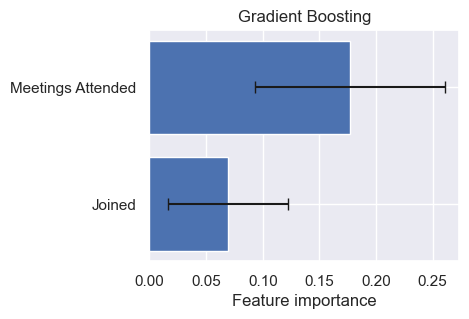

In [79]:
lgb_jm_fi = permutation_importance(lgb_jm, X1m_train, y1m_train, n_repeats=100,scoring='accuracy')

plt.barh(X1m.columns,lgb_jm_fi.importances_mean,xerr=lgb_jm_fi.importances_std,capsize=4)
plt.xlabel('Feature importance')
plt.title('Gradient Boosting')

### Random forest

In [26]:
rf_parameters = {'criterion': ['entropy'],
                     'n_estimators': [50], 'min_samples_split': [8],
                     'min_samples_leaf': [2], 'max_depth': [1],
                     'min_impurity_decrease': [0.05, 0.1, 0.2, 0.3, 0.4],'ccp_alpha':[0, 0.1], 'max_features': ['sqrt']}

In [27]:
rf_jm = GridSearchCV(
    RandomForestClassifier(random_state=67),
    rf_parameters, cv=4,n_jobs=4)

rf_jm.fit(X1m_train,y1m_train)

print("Tuned hyperparameters :",rf_jm.best_params_)
print("Accuracy on training data:",rf_jm.best_score_)
print("Accuracy on test data: ", rf_jm.score(X1m_test,y1m_test))

Tuned hyperparameters : {'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 1, 'max_features': 'sqrt', 'min_impurity_decrease': 0.05, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 50}
Accuracy on training data: 0.95
Accuracy on test data:  0.8888888888888888


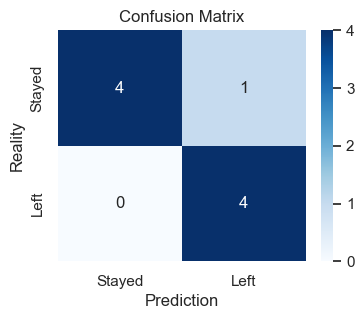

In [28]:
plot_confusion_matrix(y1m_test,rf_jm.predict(X1m_test))

Text(0.5, 1.0, 'Random Forest')

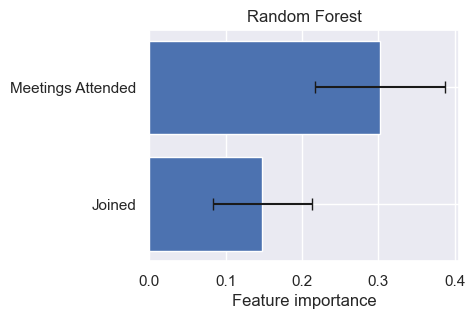

In [80]:
rf_jm_fi = permutation_importance(rf_jm, X1m_train, y1m_train,n_repeats=100,scoring='accuracy')

plt.barh(X1m.columns,rf_jm_fi.importances_mean,xerr=rf_jm_fi.importances_std,capsize=4)
plt.xlabel('Feature importance')
plt.title('Random Forest')

## Using `Last Presence` and `Joined`

Given that `Meetings Attended` and `Last Presence` are highly correlated, as we have seen [above](#correlation), I am now substituting `Last Presence` for `Meetings Attended` to check how multicollinearity might influence the result we have first seen, in which both features were included. This analysis, alongside the previous one, shall bring us insight regarding the most impactful feature in predicting churn between these very correlated features.

### Gradient boosting

In [30]:
lgbm_parameters = {'objective': ['binary'],
                  'boosting_type': ['gbdt'],
                  'n_estimators': [50],
                  'learning_rate': [0.1],
                  'deterministic': [False],
                  'force_col_wise': [True],
                  'max_depth': [1, 2],
                  'colsample_bytree': [0.2, 0.3, 1/3],
                  'min_split_gain': [0.5, 0.6],
                  'min_child_samples': [3, 4, 5],
                  'min_data_in_bin': [2, 3, 4],
                   'verbose': [-1]
                  }

lgb_jp = GridSearchCV(lgb.LGBMClassifier(random_state=32), lgbm_parameters, cv=4)
lgb_jp.fit(X1p_train, y1p_train)

print("Tuned hyperparameters :",lgb_jp.best_params_)
print("Accuracy on training data:",lgb_jp.best_score_)
print("Accuracy on test data:",lgb_jp.score(X1p_test,y1p_test))

Tuned hyperparameters : {'boosting_type': 'gbdt', 'colsample_bytree': 0.2, 'deterministic': False, 'force_col_wise': True, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_samples': 5, 'min_data_in_bin': 2, 'min_split_gain': 0.5, 'n_estimators': 50, 'objective': 'binary', 'verbose': -1}
Accuracy on training data: 0.95
Accuracy on test data: 0.8888888888888888


We again see a very accurate model, this time without `Meetings Attended`.

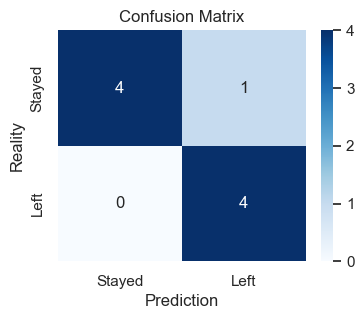

In [31]:
plot_confusion_matrix(y1p_test,lgb_jp.predict(X1p_test))

We can also see that when `Last Presence` is in the analysis, the importance of `Joined` goes down to a flat zero. This result is consistent with the importances seen when the three features were included.

Text(0.5, 1.0, 'Gradient Boosting')

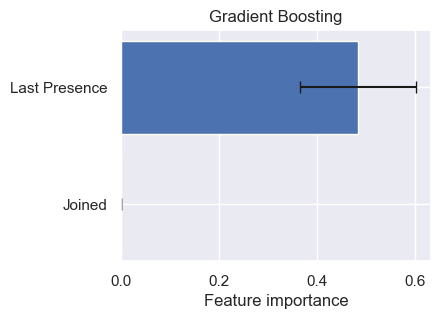

In [81]:
lgb_jp_fi = permutation_importance(lgb_jp, X1p_train, y1p_train,n_repeats=100,scoring='accuracy')

plt.barh(X1p.columns,lgb_jp_fi.importances_mean,xerr=lgb_jp_fi.importances_std, capsize=4)
plt.xlabel('Feature importance')
plt.title('Gradient Boosting')

### Random forest

In [33]:
#Random state 32
rf_parameters = {'criterion': ['entropy'],
                     'n_estimators': [50], 'min_samples_split': [5, 6, 7],
                     'min_samples_leaf': [3, 4, 5], 'max_depth': [1, 2, 3],
                     'min_impurity_decrease': [0.05, 0.1, 0.2], 'max_features': ['sqrt', 'log2']}

rf_jp = GridSearchCV(
    RandomForestClassifier(random_state=32),
    rf_parameters, cv=4,n_jobs=4)

rf_jp.fit(X1p_train,y1p_train)

print("Tuned hyperparameters :",rf_jp.best_params_)
print("Accuracy on training data:",rf_jp.best_score_)
print("Accuracy on test data: ", rf_jp.score(X1p_test,y1p_test))

Tuned hyperparameters : {'criterion': 'entropy', 'max_depth': 1, 'max_features': 'sqrt', 'min_impurity_decrease': 0.05, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy on training data: 0.95
Accuracy on test data:  0.8888888888888888


Again a very accurate model both in train and test data.

Text(0.5, 1.0, 'Random Forest')

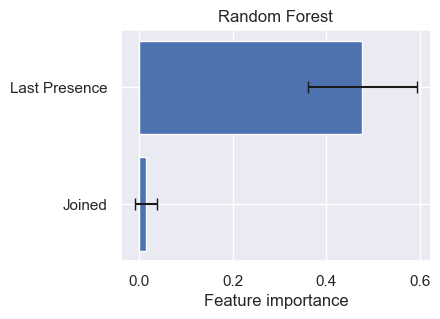

In [82]:
rf_jp_fi = permutation_importance(rf_jp, X1p_train, y1p_train,n_repeats=100,scoring='accuracy')

plt.barh(X1p.columns,rf_jp_fi.importances_mean,xerr=rf_jp_fi.importances_std, capsize=4)
plt.xlabel('Feature importance')
plt.title('Random Forest')

We see an equally accurate random forest model. As we have seen in the gradient boosting model, we see here `Last Presence` as the most important feature, with the importance of `Joined` going down to zero.

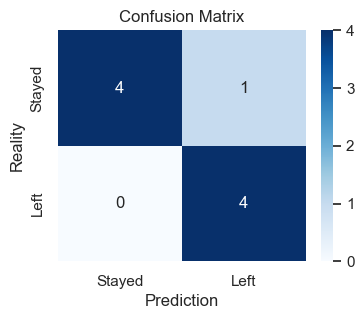

In [35]:
plot_confusion_matrix(y1p_test,rf_jp.predict(X1p_test))

From this first part of the churn prediction, it is clear that the most important feature we can use to predict whether a member will stay or leave the club is how long ago was the last time the member was present at a meeting. Although this is very correlated with the fraction of meetings the member has attended, the hiatus since the last meeting clearly holds a major importance.

The importance of `Last Presence` is not surprising at all for us who are Toastmasters. It might be surprising though, that this hiatus since the last presence at a meeting is even more important than the fraction of meetings attended as a member.

### Decision trees

Decision trees can give us a more direct interpretation regarding what distinguishes members that stay in the club from members that leave. We here build a decision tree model using the `X1` matrix.

In [36]:
decision_tree1_parameters = {'criterion':['entropy'],
                             'max_depth': [1],
                             'max_features': [1],
                             'min_samples_leaf': [6],
                             'min_samples_split': [10]}

dt_cv = GridSearchCV(DecisionTreeClassifier(random_state=18), decision_tree1_parameters, cv=4,scoring='accuracy')
dt_cv.fit(X1_train,y1_train)
print("Tuned hyperparameters :",dt_cv.best_params_)
print("Accuracy on training data :",dt_cv.best_score_)
print("Accuracy on test data: ", dt_cv.score(X1_test,y1_test))

Tuned hyperparameters : {'criterion': 'entropy', 'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 6, 'min_samples_split': 10}
Accuracy on training data : 1.0
Accuracy on test data:  0.8888888888888888


The accuracy of this decision tree model is $88.9\%$ in the test data. We only have one false positive in our predictions, i.e., one member we predicted to leave but stayed.

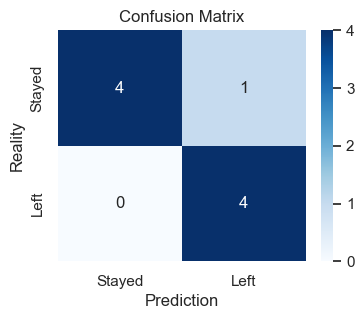

In [37]:
churn_prediction_dt1 = dt_cv.predict(X1_test)
plot_confusion_matrix(y1_test,churn_prediction_dt1)

The decision tree below shows that members who have been missing meetings for more than $40$ days have left the club. The remaining members stay in the club.

[Text(0.5, 0.75, 'Last Presence <= 40.0\nentropy = 0.998\nsamples = 19\nvalue = [10, 9]\nclass = Stayed'),
 Text(0.25, 0.25, 'entropy = 0.0\nsamples = 10\nvalue = [10, 0]\nclass = Stayed'),
 Text(0.75, 0.25, 'entropy = 0.0\nsamples = 9\nvalue = [0, 9]\nclass = Left')]

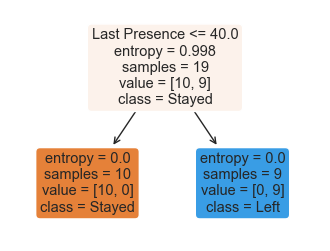

In [38]:
plot_tree(dt_cv.best_estimator_,feature_names = X1.columns, class_names = ['Stayed','Left'],filled=True,rounded=True)

We see again that `Last Presence` is the most important feature separating members who stay from members who leave the club. This result is very consistent with what we have seen both in the gradient boosting and in the random forest models.

#### Without `Meetings Attended`, the decision criterium and accuracy are the same

In [39]:
dt2_cv = GridSearchCV(DecisionTreeClassifier(random_state=21), decision_tree1_parameters, cv=4,scoring='accuracy')
dt2_cv.fit(X1p_train,y1p_train)
print("Tuned hyperparameters :",dt2_cv.best_params_)
print("Accuracy on training data:",dt2_cv.best_score_)
print("Accuracy on test data: ", dt2_cv.score(X1p_test,y1p_test))

Tuned hyperparameters : {'criterion': 'entropy', 'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 6, 'min_samples_split': 10}
Accuracy on training data: 1.0
Accuracy on test data:  0.8888888888888888


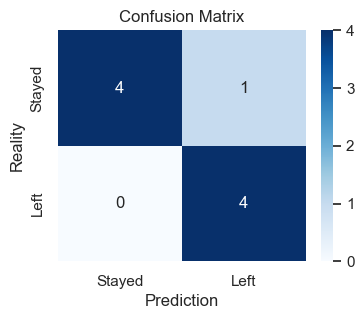

In [40]:
churn_prediction_dt2 = dt2_cv.predict(X1p_test)
plot_confusion_matrix(y1p_test,churn_prediction_dt2)

[Text(0.5, 0.75, 'Last Presence <= 40.0\nentropy = 0.998\nsamples = 19\nvalue = [10, 9]\nclass = Stayed'),
 Text(0.25, 0.25, 'entropy = 0.0\nsamples = 10\nvalue = [10, 0]\nclass = Stayed'),
 Text(0.75, 0.25, 'entropy = 0.0\nsamples = 9\nvalue = [0, 9]\nclass = Left')]

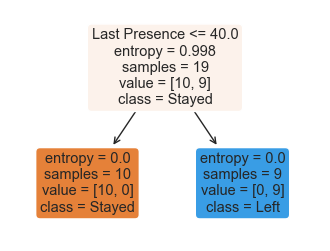

In [41]:
plot_tree(dt2_cv.best_estimator_,feature_names = X1p.columns, class_names = ['Stayed','Left'],filled=True,rounded=True)

We can see again that the feature that splits our members is `Last Presence`. If a member's last presence was more than $40$ days before our reference date, the member usually has left the club.

Gradient boosting, random forests and decision trees using `Last Presence`, `Meetings Attended` and `Joined` accurately separate members staying from members leaving and show consistently that `Last Presence`, the time passed since their last visit, is the most important feature separating members staying from members leaving. 

### The decision tree model shows that members missing more than the latest $40$ days of meetings have left the club and the remainder stay at the club.

However, I still believe I can gather even more valuable information with the dataset we have. Let's repeat the analysis, but now only with the features regarding meeting roles.

<a id='churn2'></a>
## Modelling churn II: Using meeting roles only

I would like to dig deeper to see if we can obtain more valuable and less intuitive information that distinguishes members who stay from members who leave the club. 

For that purpose, my aim is to repeat these models but using the meeting roles instead. We start here by splitting the meeting role matrix `X2` into a train and a test set.

In [42]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.3, random_state=32, stratify=y)
print(len(X2_train),'members in the training set')
print(len(X2_test),'members in the test set')

19 members in the training set
9 members in the test set


### Gradient boosting

In [43]:
lgbm2_parameters = {'objective': ['binary'],
                  'boosting_type': ['gbdt'],
                  'n_estimators': [20, 50],
                  'learning_rate': [0.006],
                  'deterministic': [False],
                  'force_col_wise': [True],
                  'max_depth': [1, 2],
                  'colsample_bytree': [0.3, 0.4],
                  'min_split_gain': [3],
                  'min_child_samples': [3, 4, 5],
                   'min_data_in_bin': [5, 6, 7],
                    'verbose':[-1]
                  }

lgb2_cv = GridSearchCV(lgb.LGBMClassifier(random_state=32), lgbm2_parameters, cv=4)
lgb2_cv.fit(X2_train, y2_train)

print("Tuned hyperparameters :",lgb2_cv.best_params_)
print("Accuracy on training data:",lgb2_cv.best_score_)
print("Accuracy on test data:",lgb2_cv.score(X2_test,y2_test))

Tuned hyperparameters : {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'deterministic': False, 'force_col_wise': True, 'learning_rate': 0.006, 'max_depth': 1, 'min_child_samples': 3, 'min_data_in_bin': 5, 'min_split_gain': 3, 'n_estimators': 50, 'objective': 'binary', 'verbose': -1}
Accuracy on training data: 0.9
Accuracy on test data: 0.8888888888888888


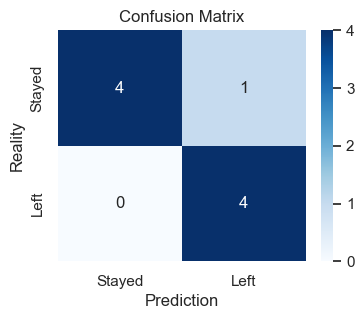

In [44]:
churn_prediction_gb2 = lgb2_cv.predict(X2_test)
plot_confusion_matrix(y2_test,churn_prediction_gb2)

Text(0.5, 1.0, 'Gradient Boosting')

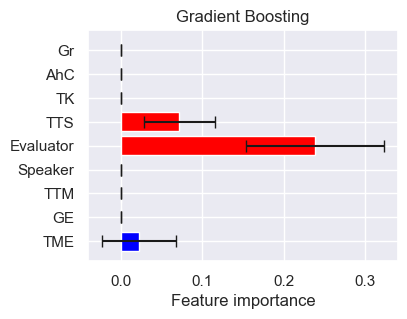

In [74]:
colors_X2 = ['red' if feature in ['TTS','Evaluator'] else 'blue' for feature in X2.columns]

lgb2_cv_fi = permutation_importance(lgb2_cv, X2_train, y2_train,n_repeats=100,scoring='accuracy')

plt.barh(X2.columns,lgb2_cv_fi.importances_mean,xerr=lgb2_cv_fi.importances_std, capsize=4, color=colors_X2)
plt.xlabel('Feature importance')
plt.title('Gradient Boosting')

According to the gradient boosting model, the roles that most frequently separate members that stay from members that leave are the evaluator and the table topic speaker `TTS`.

### Random forest

In [46]:
rf2_parameters = {'criterion': ['entropy'],
                  'n_estimators': [100], 'min_samples_split': [5],
                  'min_samples_leaf': [3],
                  'min_impurity_decrease': [0.2], 'max_features': [1, 2], 'ccp_alpha':[0.15]}

In [47]:
rf2_cv = GridSearchCV(
    RandomForestClassifier(random_state=35),
    rf2_parameters, cv=4,n_jobs=4)
rf2_cv.fit(X2_train,y2_train)
print("Tuned hyperparameters :",rf2_cv.best_params_)
print("Accuracy on training data :",rf2_cv.best_score_)

churn_prediction_rf2 = rf2_cv.predict(X2_test)
print(classification_report(y2_test, churn_prediction_rf2))

Tuned hyperparameters : {'ccp_alpha': 0.15, 'criterion': 'entropy', 'max_features': 2, 'min_impurity_decrease': 0.2, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy on training data : 0.85
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.67      1.00      0.80         4

    accuracy                           0.78         9
   macro avg       0.83      0.80      0.77         9
weighted avg       0.85      0.78      0.77         9



The random forest model here is less accurate than the gradient boosting model, with $85\%$ accuracy in the training data and $78\%$ in our test data.

Text(0.5, 1.0, 'Random Forest')

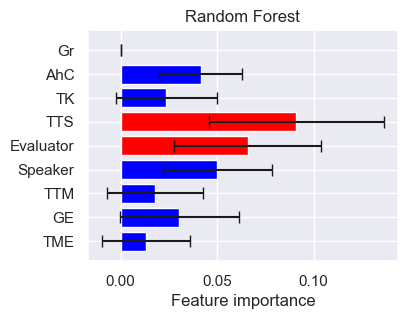

In [83]:
rf2_cv_fi = permutation_importance(rf2_cv, X2_train, y2_train,n_repeats=100,scoring='accuracy')

plt.barh(X2.columns,rf2_cv_fi.importances_mean,xerr=rf2_cv_fi.importances_std, capsize=4, color=colors_X2)
plt.xlabel('Feature importance')
plt.title('Random Forest')

The most important roles separating members that stay from members that leave under this model are the table topic speaker `TTS`, the evaluator, the speaker and the ah-counter `AhC`. The red bars above show the most important features seen in the gradient boosting model.

Given that this model is less accurate than the gradient boosting model, the importances in this model are less relevant than those given by the gradient boosting model.

In both models, the table topic speaker `TTS` and the evaluator clearly show up as a very important features separating those who stay from those who leave the club.

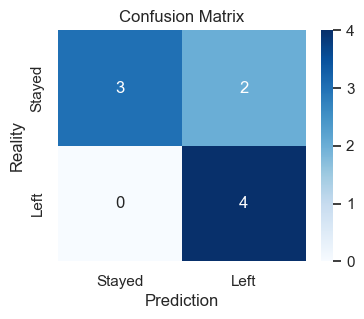

In [49]:
churn_prediction_rf2 = rf2_cv.predict(X2_test)
plot_confusion_matrix(y2_test,churn_prediction_rf2)

### Support vector machine

In [50]:
svm_parameters = {'loss': ['hinge','squared_hinge'],
                  'penalty':['l2'],'dual':[False], 'C':[0.26], 'tol':[1e-8],
                  'max_iter':[100]}

In [51]:
svm_cv = GridSearchCV(
    LinearSVC(random_state=1),
    svm_parameters, cv=4,n_jobs=4)
svm_cv.fit(X2_train,y2_train)
print("Tuned hyperparameters :",svm_cv.best_params_)
print("Accuracy on training data:",svm_cv.best_score_)

churn_prediction_svm = svm_cv.predict(X2_test)
print(classification_report(y2_test, churn_prediction_svm))

Tuned hyperparameters : {'C': 0.26, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 100, 'penalty': 'l2', 'tol': 1e-08}
Accuracy on training data: 0.7875
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.75      0.75      0.75         4

    accuracy                           0.78         9
   macro avg       0.78      0.78      0.78         9
weighted avg       0.78      0.78      0.78         9



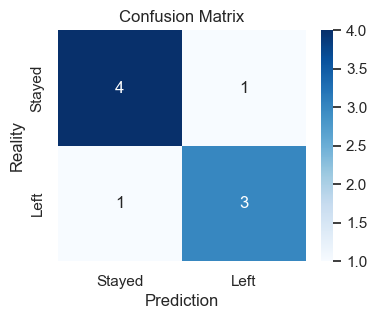

In [52]:
churn_prediction_svm = svm_cv.predict(X2_test)
plot_confusion_matrix(y2_test,churn_prediction_svm)

Text(0.5, 1.0, 'Support Vector Machine')

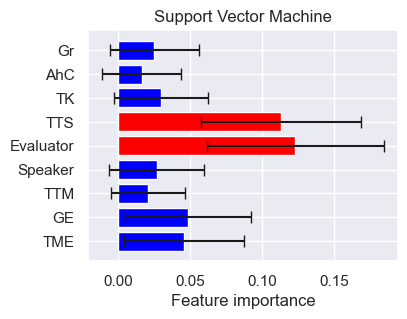

In [84]:
svm_cv_fi = permutation_importance(svm_cv, X2_train, y2_train,n_repeats=100,scoring='accuracy')

plt.barh(X2.columns,svm_cv_fi.importances_mean,xerr=svm_cv_fi.importances_std,capsize=4, color=colors_X2)
plt.xlabel('Feature importance')
plt.title('Support Vector Machine')

The support vector machine model, albeit also less accurate than the gradient boosting model, shows also the evaluator and the table topic speaker `TTS` as the most important features separating the members that stay from members that leave.

### K-nearest neighbours

In [54]:
Scaler = StandardScaler()
X2_train_transformed = Scaler.fit_transform(X2_train)
X2_test_transformed = Scaler.transform(X2_test)

In [55]:
knn_parameters = {'n_neighbors': [6]}

knn_cv = GridSearchCV(
    KNeighborsClassifier(),knn_parameters,cv=4)
knn_cv.fit(X2_train_transformed,y2_train)
print("Tuned hyperparameters :",knn_cv.best_params_)
print("Accuracy on training data:",knn_cv.best_score_)

churn_prediction_knn = knn_cv.predict(X2_test_transformed)
print(classification_report(y2_test, churn_prediction_knn))

Tuned hyperparameters : {'n_neighbors': 6}
Accuracy on training data: 0.825
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.67      1.00      0.80         4

    accuracy                           0.78         9
   macro avg       0.83      0.80      0.77         9
weighted avg       0.85      0.78      0.77         9



Text(0.5, 1.0, 'K-nearest neighbours')

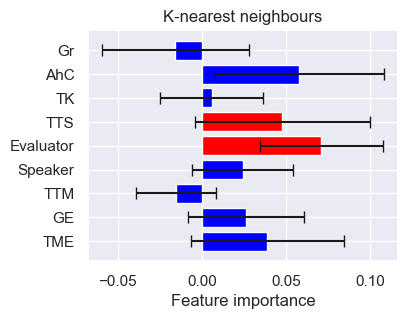

In [75]:
knn_cv_fi = permutation_importance(knn_cv, X2_train_transformed, y2_train,n_repeats=100,scoring='accuracy')

plt.barh(X2.columns,knn_cv_fi.importances_mean,xerr=knn_cv_fi.importances_std, capsize=4, color=colors_X2)
plt.xlabel('Feature importance')
plt.title('K-nearest neighbours')

The k-nearest neighbours model, albeit also less accurate than the gradient boosting model, shows as well the evaluator as one of the most important features separating the members that stay from members that leave. Under this model, the table topic speaker `TTS` no longer seems relevant.

### Decision tree

In [57]:
decision_tree2_parameters = {'criterion':['entropy'],
                             'max_features': [2, 3, 4, 5],
                             'max_depth': [1, 2, 3],
                             'min_samples_leaf': [2, 3, 4],
                             'min_samples_split': [5, 6, 7, 8],
                             'min_impurity_decrease': [0, 0.3, 0.5],
                             'ccp_alpha': [0, 0.1, 0.2]}

dt3_cv = GridSearchCV(DecisionTreeClassifier(random_state=1), decision_tree2_parameters, cv=4,scoring='accuracy')
dt3_cv.fit(X2_train,y2_train)
print("Tuned hyperparameters :",dt3_cv.best_params_)
print("Accuracy on training data :",dt3_cv.best_score_)
print("Accuracy on test data: ", dt3_cv.score(X2_test,y2_test))

Tuned hyperparameters : {'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 2, 'max_features': 5, 'min_impurity_decrease': 0, 'min_samples_leaf': 2, 'min_samples_split': 8}
Accuracy on training data : 0.9
Accuracy on test data:  0.8888888888888888


In [58]:
decision_tree3_parameters = {'criterion':['entropy'],
                             'max_features': [5],
                             'max_depth': [2],
                             'min_samples_leaf': [2],
                             'min_samples_split': [8],
                             'min_impurity_decrease': [0],
                             'ccp_alpha': [0]}

With an accuracy of $90\%$ in the train set and $88.9\%$ for the test set, this decision tree model is among the most accurate models we had so far.

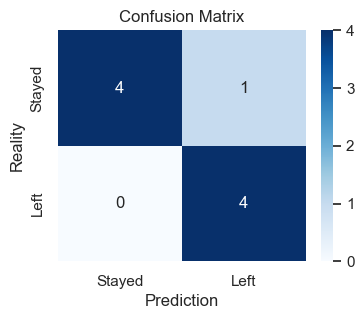

In [59]:
churn_prediction_dt3 = dt3_cv.predict(X2_test)
plot_confusion_matrix(y2_test,churn_prediction_dt3)

[Text(0.6, 0.8333333333333334, 'Evaluator <= 0.022\nentropy = 0.998\nsamples = 19\nvalue = [10, 9]\nclass = Stayed'),
 Text(0.4, 0.5, 'Speaker <= 0.079\nentropy = 0.684\nsamples = 11\nvalue = [2, 9]\nclass = Left'),
 Text(0.2, 0.16666666666666666, 'entropy = 0.0\nsamples = 9\nvalue = [0, 9]\nclass = Left'),
 Text(0.6, 0.16666666666666666, 'entropy = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = Stayed'),
 Text(0.8, 0.5, 'entropy = 0.0\nsamples = 8\nvalue = [8, 0]\nclass = Stayed')]

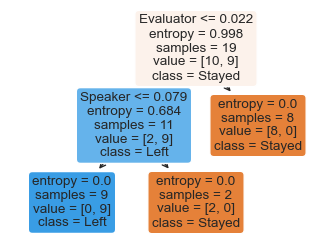

In [60]:
plot_tree(dt3_cv.best_estimator_,feature_names = X2.columns, class_names = ['Stayed','Left'],filled=True,rounded=True)

In the decision tree model, the evaluator role separates most of the members who leave from those who remain in the club. The speaker role separates the remaining members who stay. The table topic speaker `TTS`, however, does not seem relevant under this model.

It is very interesting to realize that the threshold value for the evaluator role is $0.022$. This is equivalent to taking the evaluator role once every $45$ meetings!

In [61]:
1/0.022

45.45454545454546

This means that in general a member that takes on the evaluator role once is very likely to be very committed to his development at the club and remain at the club.

On the other hand, the threshold for the speaker role is $0.079$, which is equivalent to deliver a prepared speech every $12$ meetings at least!

In [62]:
1/0.079

12.658227848101266

This season has had $22$ meetings, so these values illustrate quite well how important these roles are in separating in the decision tree model the members who have stayed from members who have left.

Text(0.5, 1.0, 'Decision Tree')

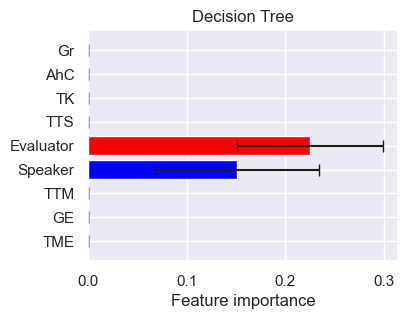

In [76]:
dt3_cv_fi = permutation_importance(dt3_cv, X2_train_transformed, y2_train, n_repeats=100, scoring='accuracy')

plt.barh(X2.columns,dt3_cv_fi.importances_mean, xerr=dt3_cv_fi.importances_std, capsize=4,color=colors_X2)
plt.xlabel('Feature importance')
plt.title('Decision Tree')

Consistently with the trees we have observed above, we can see that in the decision tree model only the evaluator and the speaker roles hold importance.

<a id='discussion'></a>
## Discussion

### Gradient boosting, random forests and decision trees using `Last Presence`, `Meetings Attended` and `Joined` accurately separate members staying from members leaving and show consistently that the time passed since their last visit is the most important feature separating members staying from members leaving. The decision tree model shows that members missing more than the latest $40$ days of meetings have left the club.

### All classification models - from the most accurate gradient boosting and decision tree models, to the less accurate random forest, k-nearest neighbour and support vector machine models - show the evaluator role as an important role separating members that stay from members that leave. The most accurate models show that the evaluator role is actually the most important role above all.

### In contrast, evidence regarding the importance of speaker and table topic speaker roles is inconsistent. Among the two most accurate models used, the gradient boosting model shows the table topic speaker as an important role and the decision tree model shows the speaker role as an important role, but none of these roles appears as important in both models.

## In any case, I recommend that we encourage members to take on the evaluator role, the speaker role and the table topic speaker role as soon as possible. We also recommend the Club Executive Commitee to engage with members who have been missing more than two Toastmasters meetings in a row. 

In a club that meets twice a month, by missing two sessions in a row, a member misses meetings for $28$ days; by missing a third session in a row, the member will be missing over $40$ days of meetings already.

Do members become more commited to their development when they take on these roles? We do not know for sure. It can be the other way around: when they remain committed to their developmental journey, they may take on these roles ever more frequently. Perhaps a bit of both.

<font color ='white'> Discuss here the correlation vs. causality - we have roles that we intentionally leave to more experienced members and these are not appearing to be as important. </a>